[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 477 out of 500 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.0s finished


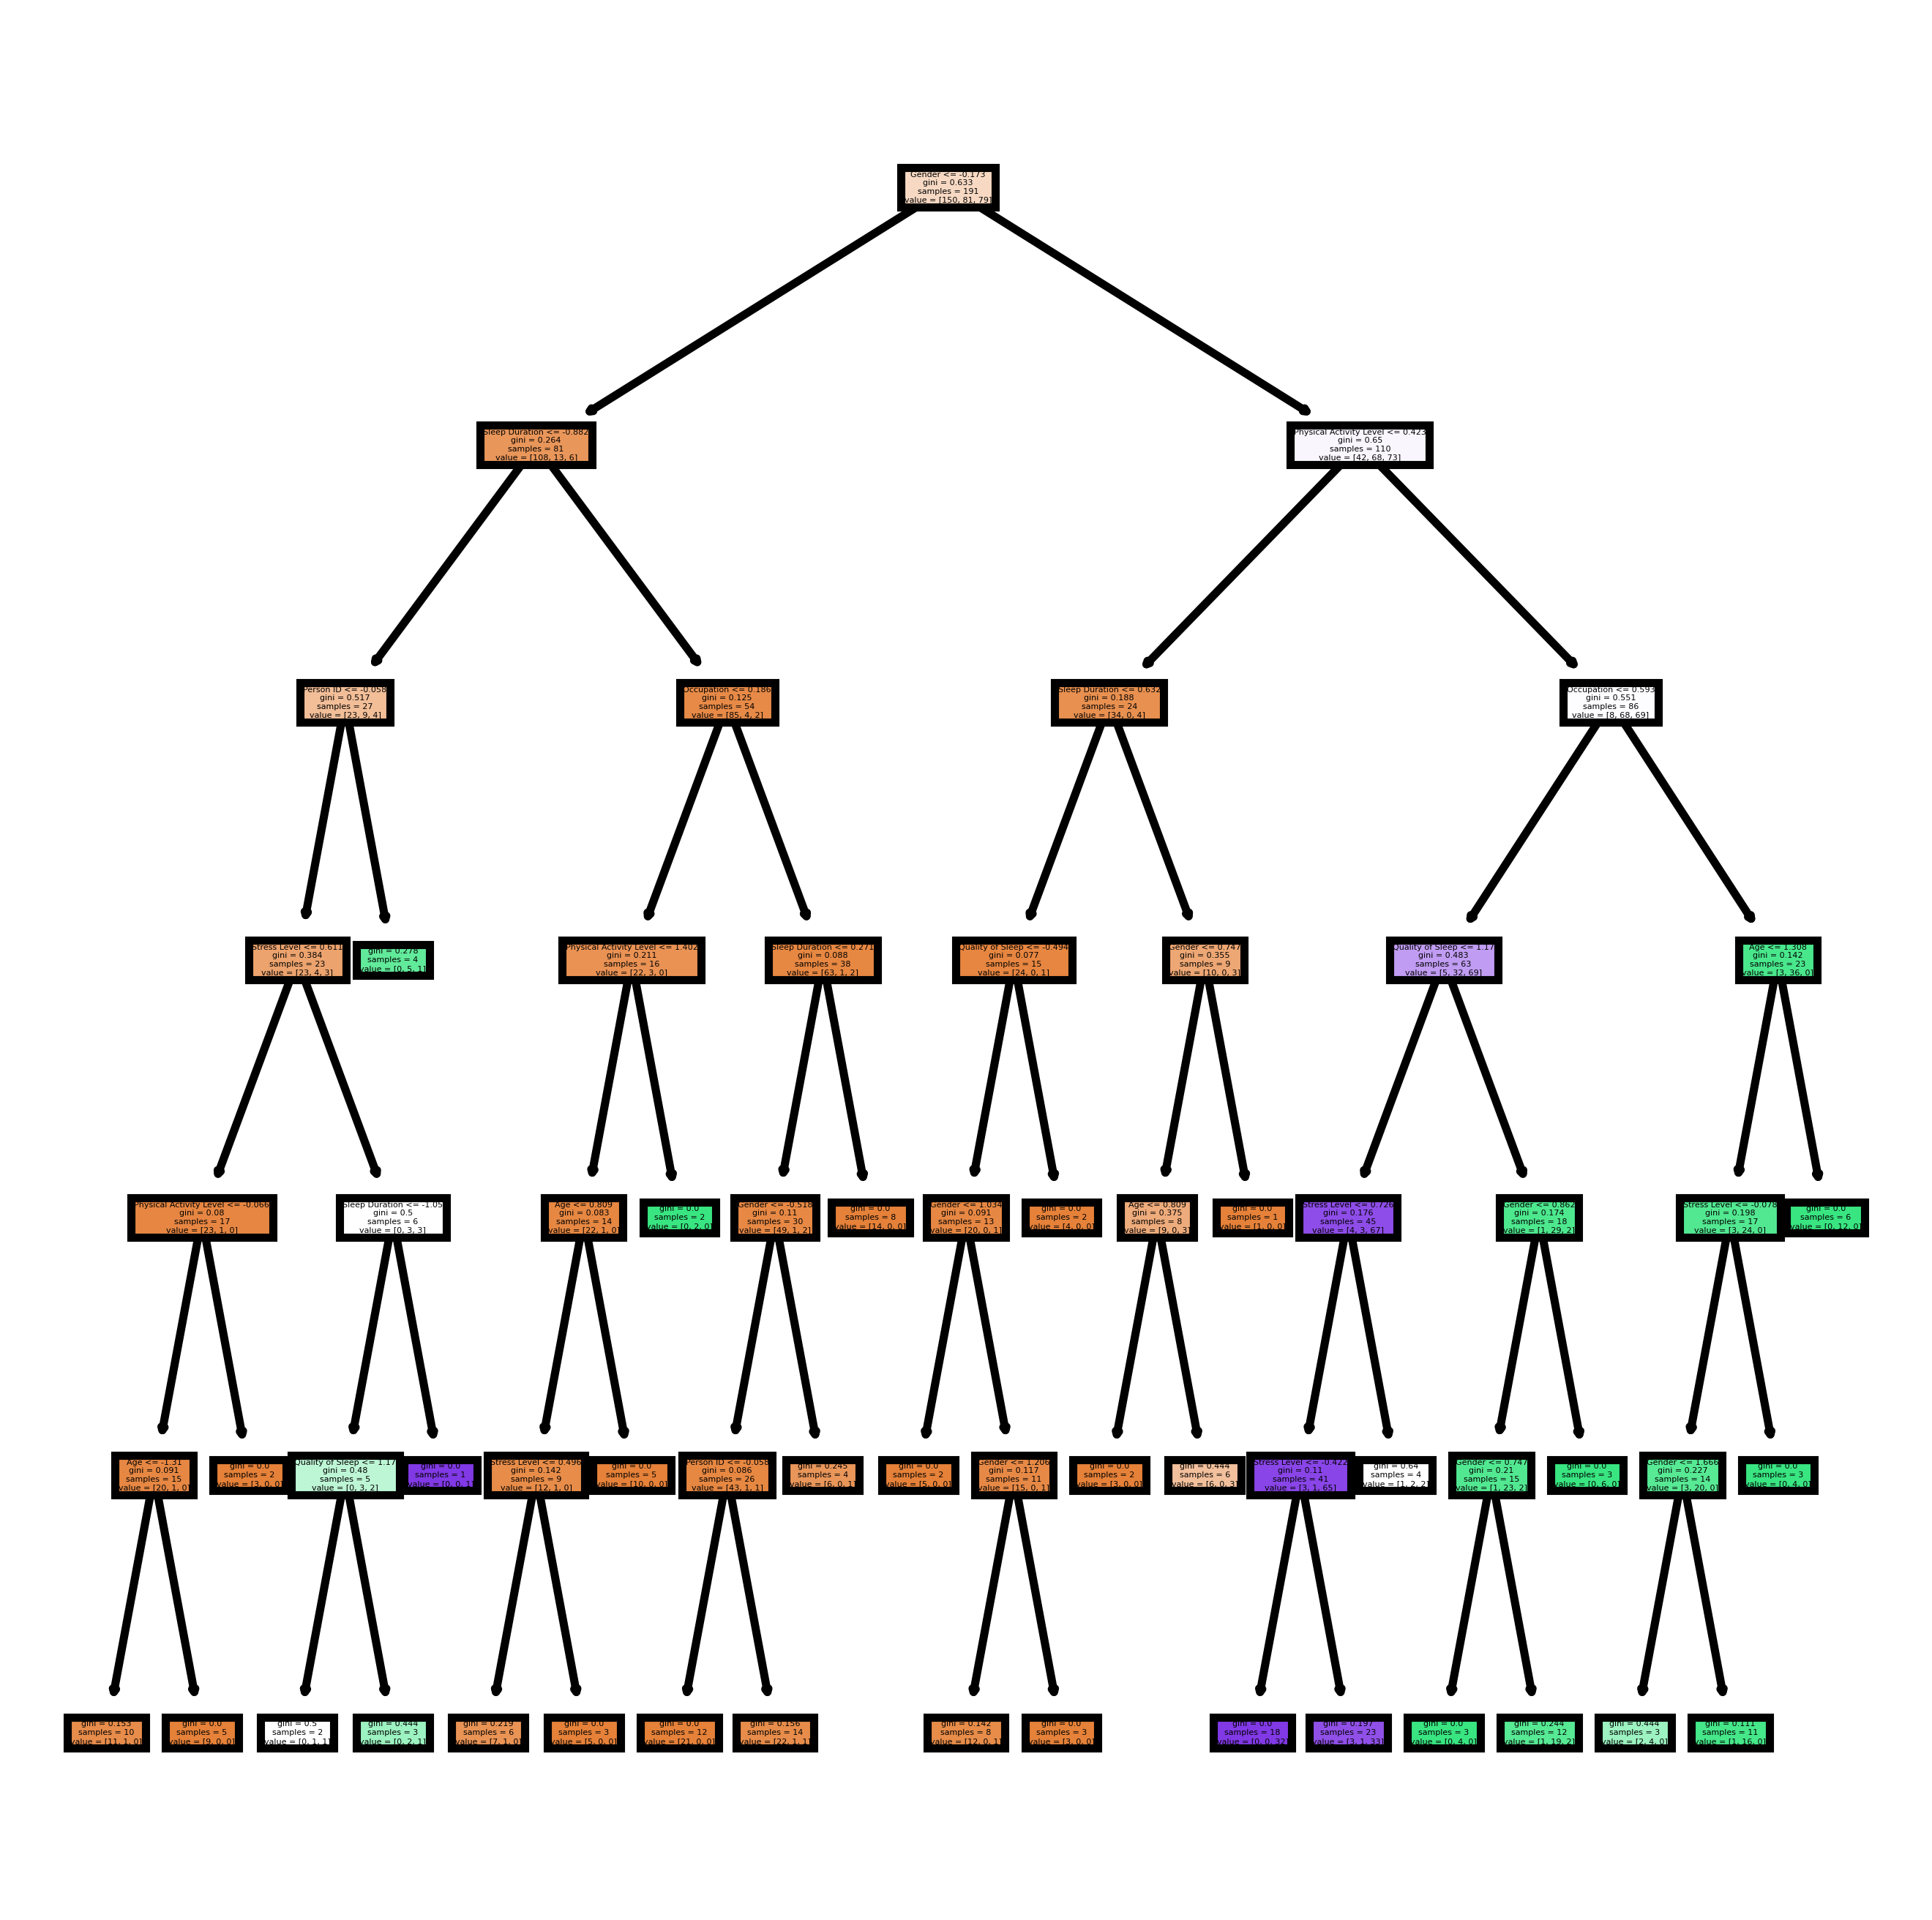

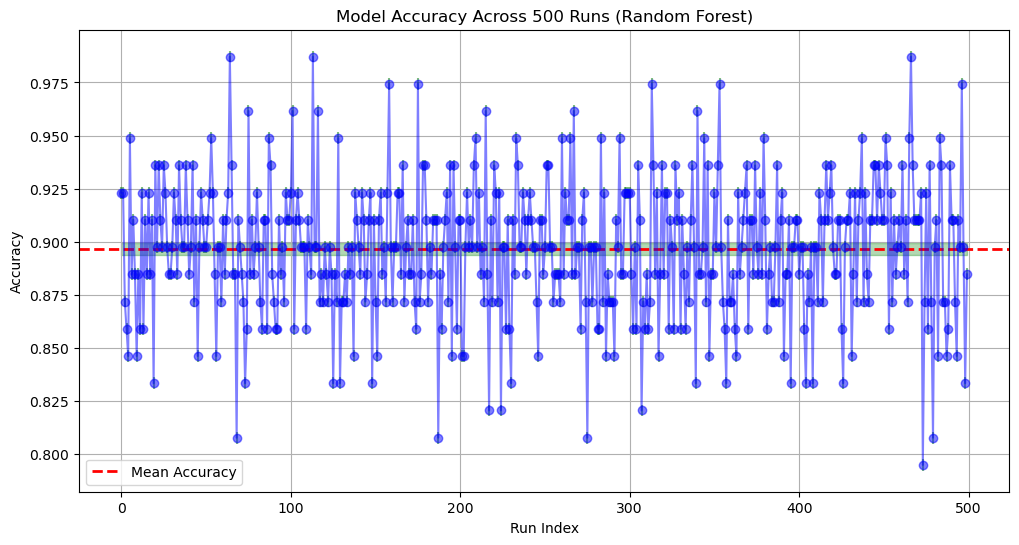

Mean Accuracy: 0.8964615384615385


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score
from sklearn import tree


# Read in data
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Replace missing values in 'Sleep Disorder' with 'None' (explicitly modify original DataFrame)
data.loc[data['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Convert classes to numbers
genders = ["Male", "Female"]
bmis = ["Normal", "Normal Weight", "Overweight", "Obese"]

for i in range(len(data)):
    data.at[i, "Gender"] = genders.index(data.at[i, "Gender"])
    data.at[i, "BMI Category"] = bmis.index(data.at[i, "BMI Category"])
    data.at[i, "BP top"] = data.at[i, "Blood Pressure"][:data.at[i, "Blood Pressure"].find("/")]
    data.at[i, "BP bottom"] = data.at[i, "Blood Pressure"][data.at[i, "Blood Pressure"].find("/") + 1:]

# Set NAs to None
data.loc[data['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Map Sleep Disorder to numerical values (None: 0, Sleep Apnea: 1, Insomnia: 2)
sleep_disorder_mapping = {'None': 0, 'Sleep Apnea': 1, 'Insomnia': 2}
data['Sleep Disorder'] = data['Sleep Disorder'].replace(sleep_disorder_mapping)

# Split positive and negative
positive = data.loc[data['Sleep Disorder'] != 0]
negative = data.loc[data['Sleep Disorder'] == 0]

# Sample each group equally
smallPos = positive.sample(n=155, random_state=1)
smallNeg = negative.sample(n=155, random_state=1)

# Combine samples and randomize
test = pd.concat([smallPos, smallNeg])
test = test.sample(frac=1, random_state=3)

# Select important columns
X = test[["Gender", "Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BMI Category", "Heart Rate"]]
y = test['Sleep Disorder']

# Scale data
scalar = StandardScaler().fit(X)
X = scalar.transform(X)

# Define model outside of pipeline for display
model = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=5, criterion='gini')

# Number of parallel runs
n_runs = 500

# Function to train and evaluate the Gradient Boosting model
def train_and_evaluate_model(seed):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # Example parameters
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run the Gradient Boosting model multiple times in parallel
results = Parallel(n_jobs=-1, verbose=1)(delayed(train_and_evaluate_model)(seed) for seed in range(n_runs))

# Fit model for display
model.fit(X, y)

# Display tree and save image
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
               feature_names = data.columns,
               filled = True);
fig.savefig('rf_individualtree.png')

# Convert results to numpy array
results_array = np.array(results)

# Calculate mean and confidence interval
mean_accuracy = np.mean(results_array)
std_deviation = np.std(results_array)
margin_of_error = 1.96 * (std_deviation / np.sqrt(n_runs))  # 95% confidence interval

# Create indices for the runs
indices = np.arange(n_runs)

# Plot the mean accuracy with confidence interval using error bars
plt.figure(figsize=(12, 6))
plt.errorbar(indices, results_array, yerr=margin_of_error, fmt='o', linestyle='-', color='b', ecolor='g', alpha=0.5)
plt.fill_between(indices, mean_accuracy - margin_of_error, mean_accuracy + margin_of_error, color='g', alpha=0.3)
plt.axhline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Run Index')
plt.ylabel('Accuracy')
plt.title(f'Model Accuracy Across {n_runs} Runs (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Accuracy: {mean_accuracy}")
